## SUPERVISED LEARNING PROJECT

# COST OF LIVING MODEL IN UNITED STATES USING MACROECONOMICS INDICATORS


The purpose of this project is to build a Supervised Machine Learning model that is using the US macroeconomic data to predict the cost of living for US householders. The cost of living target indicator that we will use is the total annual expenditure, which is published by the U.S. Bureau of Labor Statistics (BLS). The macroeconomy data that will be considered in this model is the inflation rate (Annual consumer product index (CPI)), Employment / Unemployment statistics by the U.S. Census Bureau and the Housing prices provided by the leading housing portal Zillow.

Here are the sources and reports extracted to build the dataset used in this project:

***U.S. Bureau of Labor Statistics :***

https://www.bls.gov/cex/tables.htm

1. All Urban Consumers - (Consumer Price Index - CPI)
2. Consumer Expenditure Survey (CE)

***U.S. Census Bureau :***

https://data.census.gov/

1. Employment rate by BLS region

***Zillow housing data:***

https://www.zillow.com/research/data/

1. Zillow Home Value Index (ZHVI) all homes by state

The data from these websites has been downloaded in Excel format and different formatting operations had to be performed (picking certain cells, transposing, converting, merging) in order to produce csv files ready to be imported in this notebook.


In [1]:
import scipy as sp
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
# Set color map to have light blue background
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline

## EDA Procedure

### Data Loading and Cleaning

In this section, we will load the different data set, inpect the data and make any needed transformations.

In [2]:
# This file contains the details on the US household expending per year and region. 
# It contains also the income data as well as the breadown of the expending in different categories
df_expenditure = pd.read_csv('Expenditure_data.csv')

In [3]:
df_expenditure.head()

,Year,Region,Income_before_taxes,Income_after_taxes,Expenditure_total,Food,Housing,Apparel,Transportation,Healthcare,Entertainment,Education,Insurance_pensions,Others
0,2022,Northeast,108768,93870,79741,10199,27433,2312,12093,6069,3509,2166,9995,5965
1,2022,Midwest,91430,81174,69870,8827,21907,1765,11912,6569,3701,1483,8812,4894
2,2022,South,83346,75370,65576,8443,21494,1785,11932,5376,2831,893,7422,5400
3,2022,West,103418,90354,83317,10699,28938,2104,13420,5828,4262,1326,9979,6761
4,2021,Northeast,100103,87948,72678,9334,25557,2069,9918,5759,3483,1839,9209,5510


In [4]:
df_expenditure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Year                 44 non-null     int64 
 1   Region               44 non-null     object
 2   Income_before_taxes  44 non-null     int64 
 3   Income_after_taxes   44 non-null     int64 
 4   Expenditure_total    44 non-null     int64 
 5   Food                 44 non-null     int64 
 6   Housing              44 non-null     int64 
 7   Apparel              44 non-null     int64 
 8   Transportation       44 non-null     int64 
 9   Healthcare           44 non-null     int64 
 10  Entertainment        44 non-null     int64 
 11  Education            44 non-null     int64 
 12  Insurance_pensions   44 non-null     int64 
 13  Others               44 non-null     int64 
dtypes: int64(13), object(1)
memory usage: 4.9+ KB


In [5]:
# This file contains the macroeconomic information (employment and unemployment rate per year and region)
df_employment = pd.read_csv('Employment_data.csv')

In [6]:
df_employment.head()

,Year,Region,Employment_rate,Unemployment_rate
0,2022,Northeast,61.00%,4.60%
1,2022,Midwest,61.70%,3.80%
2,2022,South,59.20%,4.20%
3,2022,West,60.40%,4.60%
4,2021,Northeast,59.00%,7.40%


In [7]:
df_employment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Year               44 non-null     int64 
 1   Region             44 non-null     object
 2   Employment_rate    44 non-null     object
 3   Unemployment_rate  44 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.5+ KB


In [8]:
# Since the rates are loaded as object, we need to convert these two attribute to numeric
df_employment['Employment_rate'] = df_employment['Employment_rate'].str.rstrip('%').astype('float') / 100
df_employment['Unemployment_rate'] = df_employment['Unemployment_rate'].str.rstrip('%').astype('float') / 100

In [9]:
df_employment.head()

,Year,Region,Employment_rate,Unemployment_rate
0,2022,Northeast,0.610,0.046
1,2022,Midwest,0.617,0.038
2,2022,South,0.592,0.042
3,2022,West,0.604,0.046
4,2021,Northeast,0.590,0.074


In [10]:
# This file contains the evolution of the Consumer Price Index (CPI) by year and region
df_CPI = pd.read_csv('CPI_data.csv')

In [11]:
df_CPI.head()

,Year,Region,Annual_CPI
0,2012,Northeast,245.698
1,2013,Northeast,249.038
2,2014,Northeast,252.463
3,2015,Northeast,252.185
4,2016,Northeast,254.850


In [12]:
df_CPI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        44 non-null     int64  
 1   Region      44 non-null     object 
 2   Annual_CPI  44 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ KB


In [13]:
# Last, this is the evolution of the average house price per year and region
df_housing = pd.read_csv('Housing_data.csv')

In [14]:
df_housing.head()

,Year,Region,House_price
0,2012,Midwest,131822.1934
1,2013,Midwest,139825.3620
2,2014,Midwest,145371.2890
3,2015,Midwest,153770.0406
4,2016,Midwest,159955.5674


In [15]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         44 non-null     int64  
 1   Region       44 non-null     object 
 2   House_price  44 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ KB


In [16]:
# We will not merge the 4 files into a single dataframe by joining the dataframes by year and region
#Perform an inner join based on equality between Year and Region
merged_df1 = pd.merge(df_expenditure, df_employment, left_on=['Year', 'Region'], right_on=['Year', 'Region'], how='inner')
merged_df2 = pd.merge(df_CPI, df_housing, left_on=['Year', 'Region'], right_on=['Year', 'Region'], how='inner')
df = pd.merge(merged_df1, merged_df2, left_on=['Year', 'Region'], right_on=['Year', 'Region'], how='inner')

In [17]:
df.head()


,Year,Region,Income_before_taxes,Income_after_taxes,Expenditure_total,Food,Housing,Apparel,Transportation,Healthcare,Entertainment,Education,Insurance_pensions,Others,Employment_rate,Unemployment_rate,Annual_CPI,House_price
0,2022,Northeast,108768,93870,79741,10199,27433,2312,12093,6069,3509,2166,9995,5965,0.610,0.046,303.320,400411.3643
1,2022,Midwest,91430,81174,69870,8827,21907,1765,11912,6569,3701,1483,8812,4894,0.617,0.038,272.401,241918.1104
2,2022,South,83346,75370,65576,8443,21494,1785,11932,5376,2831,893,7422,5400,0.592,0.042,283.666,290890.0814
3,2022,West,103418,90354,83317,10699,28938,2104,13420,5828,4262,1326,9979,6761,0.604,0.046,310.509,489353.0737
4,2021,Northeast,100103,87948,72678,9334,25557,2069,9918,5759,3483,1839,9209,5510,0.590,0.074,283.557,366749.1869


## Data visualization

Once the data is loaded in a single dataframe, we are now in the position to visualize the data to gain insights and determine already what could be the most appropriate models and features.
We will start by visualizing the **expenditure by region over the years**.

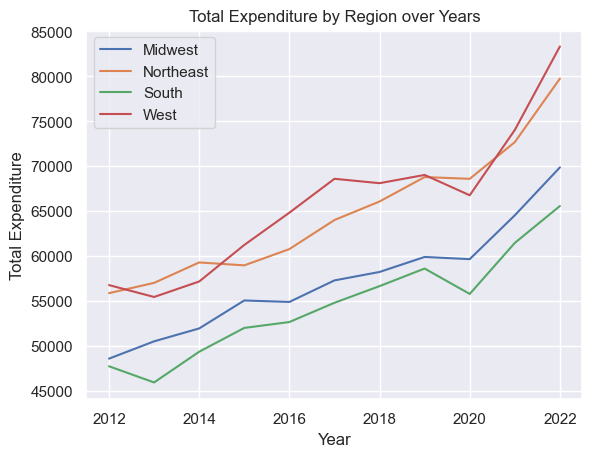

In [18]:
# Create a figure and axis to plot on
fig, ax = plt.subplots()

# Iterate through unique regions and plot each series separately
for region, data in df.groupby('Region'):
    ax.plot(data['Year'], data['Expenditure_total'], label=region)

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Total Expenditure')
ax.set_title('Total Expenditure by Region over Years')

# Show a legend
ax.legend()

# Show the plot
plt.show()

As expected the trend of the expenditure is overall ascending for all regions. However it is curious to see that in 2020 the expenditure decreased in all regions, clearly an effect of the COVID19 pandemic.

We will now go on with the visualization of the total expenditure versus the Macroeconomic data. 
We will start by plotting the ***Average expenditure vs Unemployment rate.***

*Unemployment rate value has been multiplied by $10^6$ to be able to represent both values in the same range*.

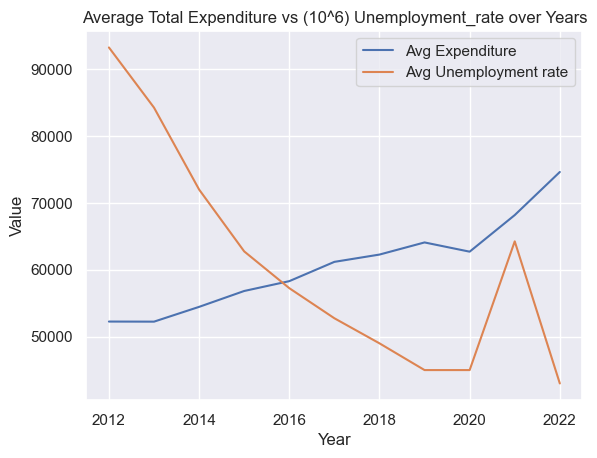

In [19]:

# Grouping the DataFrame by 'Year' and 'Region' and calculating the mean for 'Expenditure_total' and 'Unemployment_rate'
yearly_region_means = df.groupby(['Year', 'Region'])[['Expenditure_total', 'Unemployment_rate']].mean().reset_index()

# Calculating the average values for each year after grouping by 'Region'
yearly_means = yearly_region_means.groupby('Year')[['Expenditure_total', 'Unemployment_rate']].mean().reset_index()

# Create a figure and axis to plot on
fig, ax = plt.subplots()

# Plotting 'Expenditure_total' and 'Unemployment_rate' averaged over regions against 'Year' as lines
ax.plot(yearly_means['Year'], yearly_means['Expenditure_total'], label='Avg Expenditure')
ax.plot(yearly_means['Year'], 1000000*yearly_means['Unemployment_rate'], label='Avg Unemployment rate')

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Value')
ax.set_title('Average Total Expenditure vs (10^6) Unemployment_rate over Years')

# Show the legend
ax.legend()

# Show the plot
plt.show()


As it could be anticipated, a decline in unemployement rate for 2012 to 2022 translates in an increase of average expenditure. 

Because of the pandemic the unemployment data for 2020 was not available and hence the 2019 value was used. One can see the effect of the pandemic in 2021 as the unemployment rate peak due to the lockdowns and freeze of the economy.Also it rapidly went down again in 2020 to lower values than 2019. 

It is also noticeable that the expenditure only decrease slightly in 2020 and swiftly recover the ascending trend in 2021 and 2022 thanks to the government stimuli and low interest rates. 

Because of this anomaly in the behavior in 2021, one can expect that the unemployment rate will not be the best predictor for average expenditure.

Let's explore now the effect of inflation with the graph showing ***Average Total Expenditure vs Annual CPI.***

*Again, CPI values have been multiplied by $10^3$ to keep both variables in the same range **.

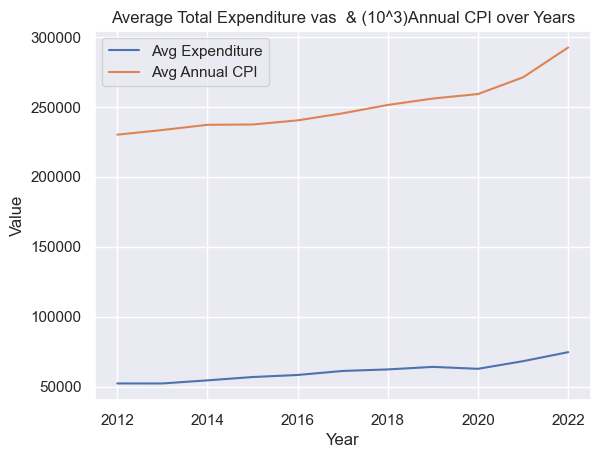

In [20]:
# Grouping the DataFrame by 'Year' and 'Region' and calculating the mean for 'Expenditure_total' and 'Annual_CPI'
yearly_region_means = df.groupby(['Year', 'Region'])[['Expenditure_total', 'Annual_CPI']].mean().reset_index()

# Calculating the average values for each year after grouping by 'Region'
yearly_means = yearly_region_means.groupby('Year')[['Expenditure_total', 'Annual_CPI']].mean().reset_index()

# Create a figure and axis to plot on
fig, ax = plt.subplots()

# Plotting 'Expenditure_total' and 'Annual_CPI' averaged over regions against 'Year' as lines
ax.plot(yearly_means['Year'], yearly_means['Expenditure_total'], label='Avg Expenditure')
ax.plot(yearly_means['Year'], 1000*yearly_means['Annual_CPI'], label='Avg Annual CPI')

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Value')
ax.set_title('Average Total Expenditure vas  & (10^3)Annual CPI over Years')

# Show the legend
ax.legend()

# Show the plot
plt.show()


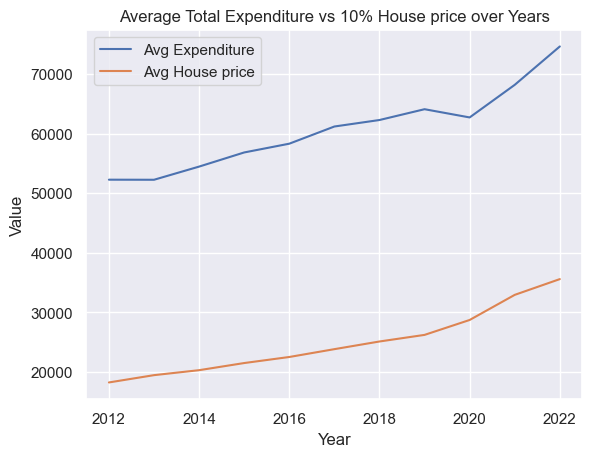

In [21]:
# Grouping the DataFrame by 'Year' and 'Region' and calculating the mean for 'Expenditure_total' and 'House_price'
yearly_region_means = df.groupby(['Year', 'Region'])[['Expenditure_total', 'House_price']].mean().reset_index()

# Calculating the average values for each year after grouping by 'Region'
yearly_means = yearly_region_means.groupby('Year')[['Expenditure_total', 'House_price']].mean().reset_index()

# Create a figure and axis to plot on
fig, ax = plt.subplots()

# Plotting 'Expenditure_total' and 'House_price' averaged over regions against 'Year' as lines
ax.plot(yearly_means['Year'], yearly_means['Expenditure_total'], label='Avg Expenditure')
ax.plot(yearly_means['Year'], 0.1*yearly_means['House_price'], label='Avg House price')

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Value')
ax.set_title('Average Total Expenditure vs 10% House price over Years')

# Show the legend
ax.legend()

# Show the plot
plt.show()

The trend of both expenditure and house price is clearly ascending as housing is one of the most important expenditures for houshold. For that reason we expect it to be a good predictor of total expending.
We se that, again in 2020 because of the the pandemic, the expenditure decrease slightly while house prices actually increase at a faster rate. This was a well known event that was caused by the fact that fewer houses were put in the market because of the "stay home" policies and, because of the low supply the house prices increased 

# Model building

We are now in a position to start building our model (or models) to predict the total expenditure based on the data and insights obtained in the visualization.

###  Data adaptation
As and additional data manipulation, we will convert the Region attribute (that has text values) into numeric. This is mandatory if we want the Region to play a role in the numeric regression and models and therefore maintain the influence of the region in the overall prediction.


In [22]:
# Convert 'Region' column to categorical type
# Define a mapping dictionary for string to numeric representation
region_mapping = {'Northeast': 100, 'Midwest': 200, 'South': 300, 'West': 400}

# Convert categorical variable to numeric
df['Region_num'] = df['Region'].map(region_mapping)

In [23]:
df.head()

,Year,Region,Income_before_taxes,Income_after_taxes,Expenditure_total,Food,Housing,Apparel,Transportation,Healthcare,Entertainment,Education,Insurance_pensions,Others,Employment_rate,Unemployment_rate,Annual_CPI,House_price,Region_num
0,2022,Northeast,108768,93870,79741,10199,27433,2312,12093,6069,3509,2166,9995,5965,0.610,0.046,303.320,400411.3643,100
1,2022,Midwest,91430,81174,69870,8827,21907,1765,11912,6569,3701,1483,8812,4894,0.617,0.038,272.401,241918.1104,200
2,2022,South,83346,75370,65576,8443,21494,1785,11932,5376,2831,893,7422,5400,0.592,0.042,283.666,290890.0814,300
3,2022,West,103418,90354,83317,10699,28938,2104,13420,5828,4262,1326,9979,6761,0.604,0.046,310.509,489353.0737,400
4,2021,Northeast,100103,87948,72678,9334,25557,2069,9918,5759,3483,1839,9209,5510,0.590,0.074,283.557,366749.1869,100


### Data trimming and sorting

As a final data cleaning, we are going to remove most of the attributes that represent a breakdown of the total expenses (food, apparel, etc) since these are highly correlated with the total. 

Also we will remove the Income_after_taxes which is also highly correlated with the Income_before_taxes.

Finally, the Region will also be removed since it is already converted to a numeric value for regressions.

The resulting dataframe will be sorted by Year and Region_num for visualization purposes.

In [24]:
# drop unnecessary features, replace df
df = df.drop(columns=['Region','Food','Apparel','Others','Housing','Insurance_pensions','Education','Entertainment','Income_after_taxes'])
df = df.sort_values(by=['Year', 'Region_num'])

### Inspection, correlation and pair plot

In the following section we will perform analysis and visualization for the target data point (Expenditure_total) and the rest of feature in order to determine which one are the best predictor for the supervised models.

In [25]:
df.corr()

,Year,Income_before_taxes,Expenditure_total,Transportation,Healthcare,Employment_rate,Unemployment_rate,Annual_CPI,House_price,Region_num
Year,1.000000e+00,0.788233,0.766206,0.754656,0.913263,0.455044,-0.796998,0.758988,0.619357,-8.119262e-15
Income_before_taxes,7.882331e-01,1.000000,0.959763,0.672039,0.751645,0.498494,-0.529885,0.926128,0.866853,-1.077857e-01
Expenditure_total,7.662065e-01,0.959763,1.000000,0.758304,0.747309,0.470976,-0.509381,0.935513,0.905532,1.311512e-02
Transportation,7.546557e-01,0.672039,0.758304,1.000000,0.676912,0.202244,-0.471205,0.749910,0.684320,3.139452e-01
Healthcare,9.132629e-01,0.751645,0.747309,0.676912,1.000000,0.657441,-0.808730,0.645862,0.486141,-1.417233e-01
Employment_rate,4.550436e-01,0.498494,0.470976,0.202244,0.657441,1.000000,-0.671436,0.303436,0.164862,-4.760350e-01
Unemployment_rate,-7.969976e-01,-0.529885,-0.509381,-0.471205,-0.808730,-0.671436,1.000000,-0.437008,-0.282565,1.149371e-01
Annual_CPI,7.589880e-01,0.926128,0.935513,0.749910,0.645862,0.303436,-0.437008,1.000000,0.925865,-2.926100e-02
House_price,6.193570e-01,0.866853,0.905532,0.684320,0.486141,0.164862,-0.282565,0.925865,1.000000,2.195661e-01
Region_num,-8.119262e-15,-0.107786,0.013115,0.313945,-0.141723,-0.476035,0.114937,-0.029261,0.219566,1.000000e+00


### Correlation Matrix using a Heatmap

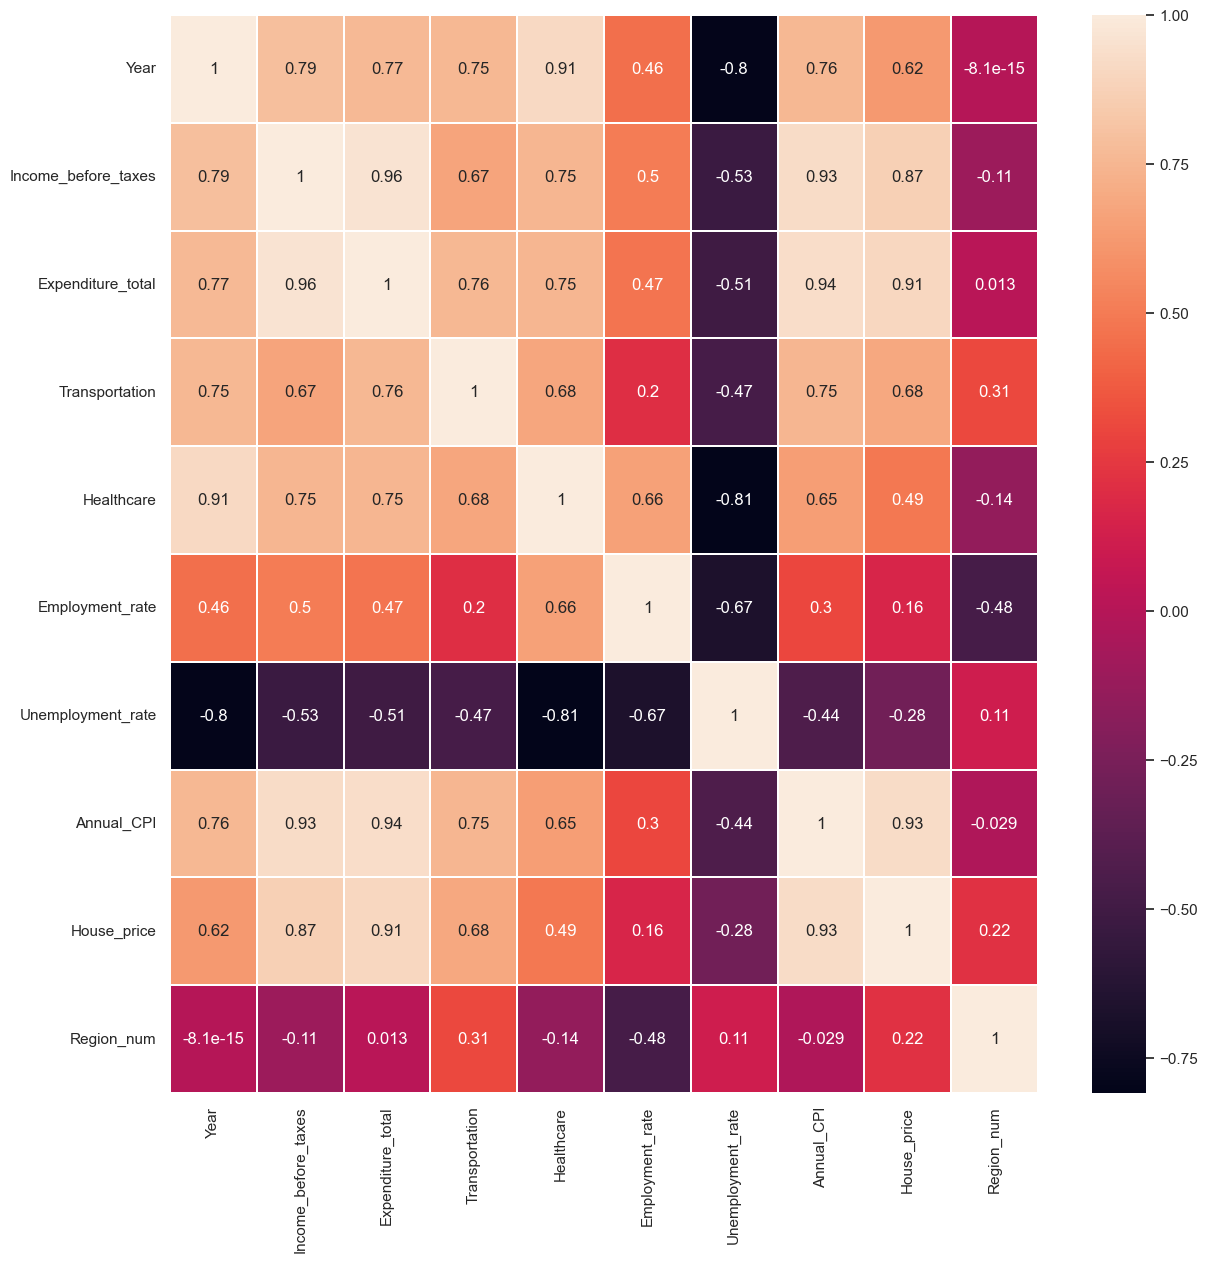

In [26]:
# visualizing correlation matrix using a heatmap
fig, ax = plt.subplots (figsize=(14, 14))
sns.heatmap (df.corr(), linewidths=.3,annot=True)
plt.show ()

### Pair Plot

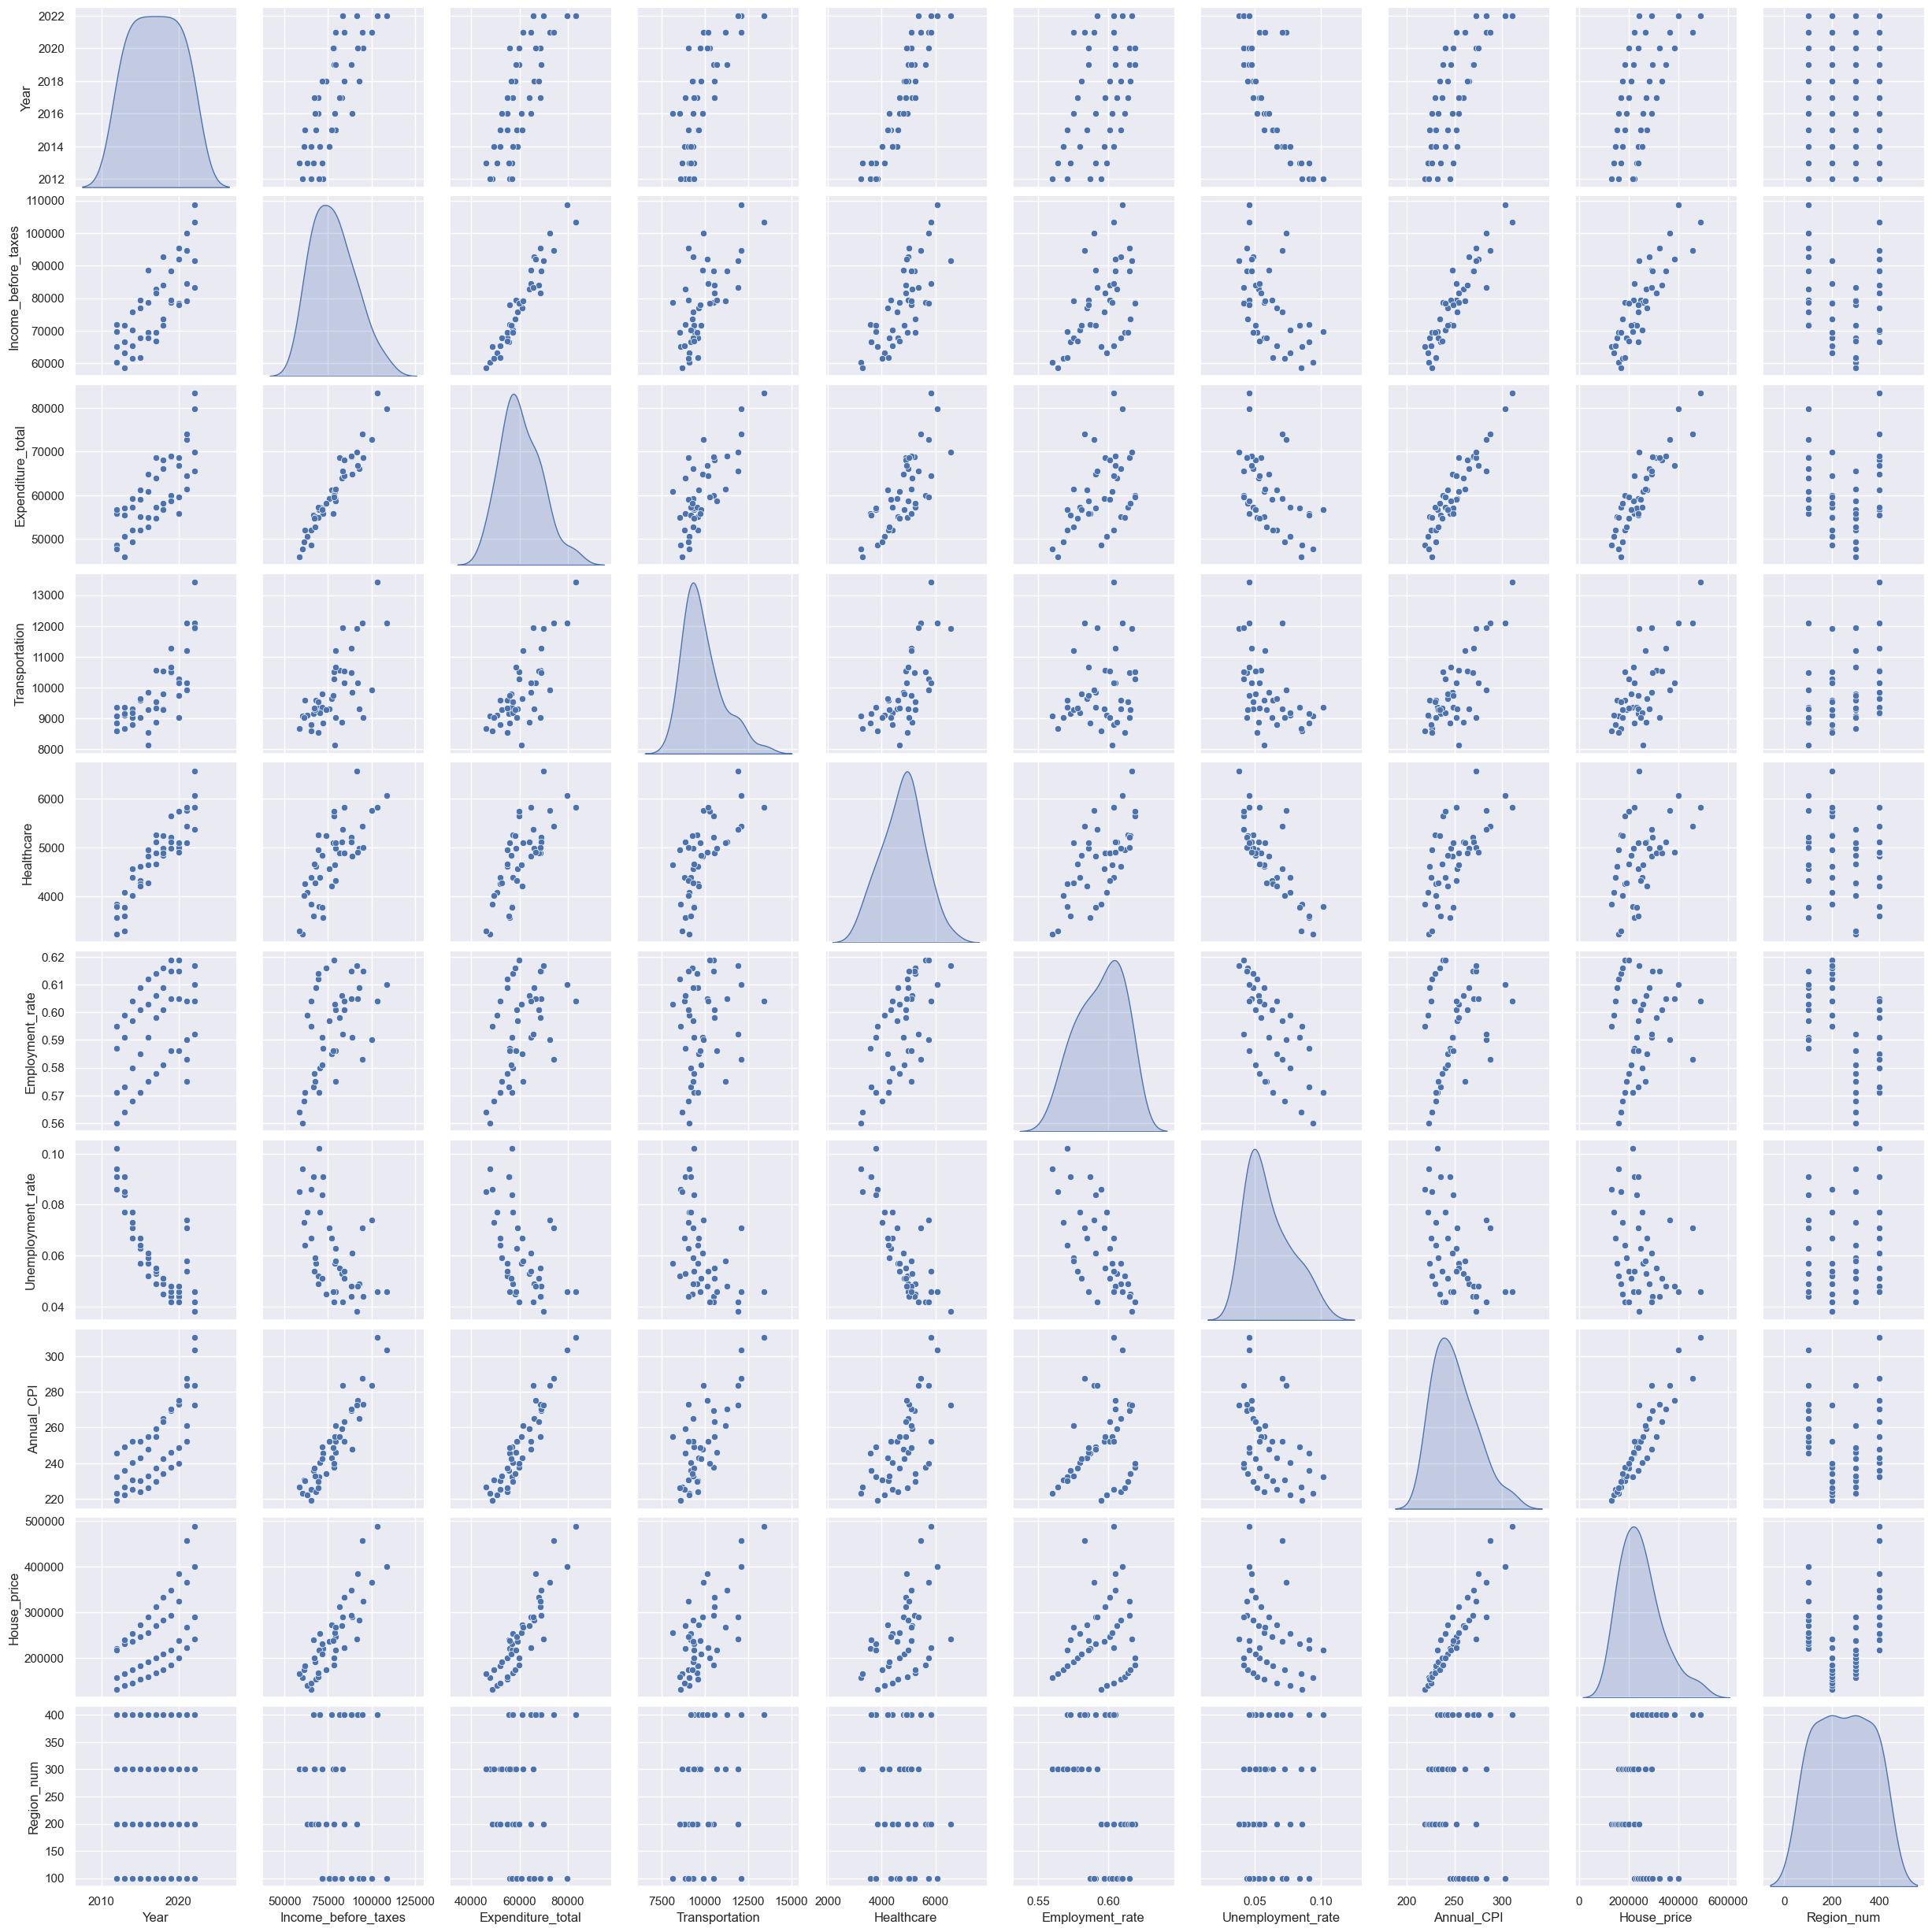

In [27]:
df_10 = df.iloc[:, : 10]


sns.pairplot(df_10, diag_kind="kde")


Based on the results above, the feature Income_before_taxes seems to be the best predictor (coef = 0.959763	)to determine the Expenditure_total, which makes a lot of sense as households spend in accordance to their income.

Other features will also show good correlation with the target variable and will be considered in the next steps.

## Simple linear regression


### Model & training

In this section we will use a simple linear regression model to fit the data. 

First we will split the dataset in train and test partition. Since this is a time evolution, we will use the data from years 2012 to 2020 as training and the last two years (2021,2022) as test. 

This way using past values of the target variable as features can help the model learn temporal patterns.

Below, we will first attempt each of the features as predictors and select the one that obtains best results, i.e., the maximum $R^2$ score.

In [28]:
#simple one variable regression

X_train = df[(df['Year'] >= 2012) & (df['Year'] <= 2020)]
X_test = df[(df['Year'] >= 2021) & (df['Year'] <= 2022)]

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
Y_test = X_test['Expenditure_total']  # Target variable
Y_train = X_train['Expenditure_total']  # Target variable

best_feature = None
max_r2_score = -float('inf')

columns = X_train.columns
variables = []
form =''
for c in columns:
    if c != 'Expenditure_total' :
            form = 'Expenditure_total' + ' ~ ' + c
            model = smf.ols(formula=form, data=X_train)
            res = model.fit()
            variables.append([c,res.rsquared])
            if res.rsquared > max_r2_score:
                max_r2_score = res.rsquared
                best_feature = c
                best_mod = res

    
print('Best predictor : ', best_feature)
print('Max R2 score :', max_r2_score)
print(best_mod.summary())

X_train: (36, 10)
X_test: (8, 10)
Best predictor :  Income_before_taxes
Max R2 score : 0.8798355503489361
                            OLS Regression Results                            
Dep. Variable:      Expenditure_total   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     248.9
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           3.28e-17
Time:                        20:51:38   Log-Likelihood:                -327.95
No. Observations:                  36   AIC:                             659.9
Df Residuals:                      34   BIC:                             663.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------

### Results

as already anticipated, the best predictor turns out to be the Income_before_taxes. It delivers a 0.880 R-squared value, which is already not bad.

Now we will use the model generated with simple predictor and plot the actual results versus the ones predicted by the simple linear model using the single best predictor. 


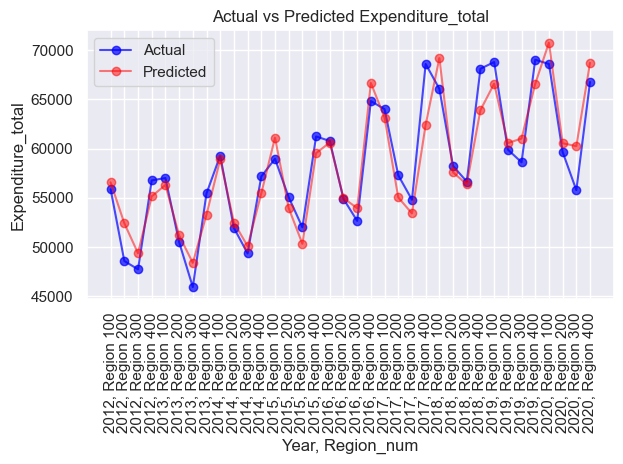

In [29]:
# Predict using the test data
model = best_mod
Y_pred = model.predict(X_train)

# Extracting the 'Year', 'Expenditure_total', and 'Region_num' values for the test data
years = X_train['Year'].values
region_nums = X_train['Region_num'].values

# Combine 'Year' and 'Region_num' to form a combined label for x-axis
x_ticks_labels = [f"{year}, Region {region_num}" for year, region_num in zip(years, region_nums)]

# Scatter plot for actual 'Expenditure_total' values with combined 'Year' and 'Region_num' labels on x-axis
plt.plot(x_ticks_labels, Y_train, color='blue', label='Actual', marker='o', linestyle='-',alpha=0.7)

# Scatter plot for predicted 'Expenditure_total' values with combined 'Year' and 'Region_num' labels on x-axis
plt.plot(x_ticks_labels, Y_pred, color='red', label='Predicted', marker='o', linestyle='-',alpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Labels and title
plt.xlabel('Year, Region_num')
plt.ylabel('Expenditure_total')
plt.title('Actual vs Predicted Expenditure_total')

# Show legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

Now we will use that same model to predict the target variable using the test data.

We will plot the results and compare the accuracy of the prediction versus the actuals.

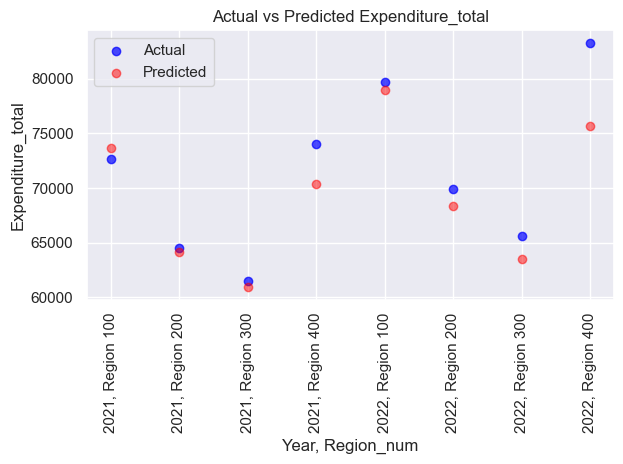

In [30]:
# Predict using the test data
model = best_mod
Y_pred = model.predict(X_test)

# Extracting the 'Year', 'Expenditure_total', and 'Region_num' values for the test data
years = X_test['Year'].values
region_nums = X_test['Region_num'].values

# Combine 'Year' and 'Region_num' to form a combined label for x-axis
x_ticks_labels = [f"{year}, Region {region_num}" for year, region_num in zip(years, region_nums)]

# Scatter plot for actual 'Expenditure_total' values with combined 'Year' and 'Region_num' labels on x-axis
plt.scatter(x_ticks_labels, Y_test, color='blue', label='Actual', alpha=0.7)

# Scatter plot for predicted 'Expenditure_total' values with combined 'Year' and 'Region_num' labels on x-axis
plt.scatter(x_ticks_labels, Y_pred, color='red', label='Predicted', alpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Labels and title
plt.xlabel('Year, Region_num')
plt.ylabel('Expenditure_total')
plt.title('Actual vs Predicted Expenditure_total')

# Show legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

As it can be observed already, the predicted values is quite accurate with the exception of the value for 2022 in the Region 400 (West). 

In the previous data visualization, we observed that in 2020 for the West Region, there was a spike of expenditure, surpassing for the first time the Northeast region. So, since the model was built in "past" data, it is normal that the value was not accurately predicted as it really constituted a change of tendency in 2022.

We will finalize this section by determining what are the top 5 predictors in the dataset for usage in next analysis.  

The results are displayed below.


In [31]:
columns = X_train.columns
variables = []
form =''
for c in columns:
    if c != 'Expenditure_total' :
            form = 'Expenditure_total' + ' ~ ' + c
            model = smf.ols(formula=form, data=X_train)
            res = model.fit()
            variables.append([c,res.rsquared_adj])
     
            
        
# uncomment and update top_five
sorted_data = sorted(variables, key=lambda x: x[1], reverse=True)
top_all = sorted_data[:5]
top_all = [item[0] for item in top_all]
print(top_all)

['Income_before_taxes', 'Annual_CPI', 'House_price', 'Year', 'Healthcare']


## Multi linear regression

### Model and training

I this section we will use a simple linear regression model to fit the data. 

Again, we will split the dataset in train and test partition. Since this is a time evolution, we will use the data from years 2012 to 2020 as training and the last two years (2021,2022) as test. 

We will then remove the target variable from the features files (X) and add it to the target variable file both for the training and test datasets.

In [32]:

# Filter the DataFrame for the required years
train_data = df[(df['Year'] >= 2012) & (df['Year'] <= 2020)]
test_data = df[(df['Year'] >= 2021) & (df['Year'] <= 2022)]

# Define features and target variable for training data
X_train = train_data.drop(['Expenditure_total'], axis=1)  # Features
Y_train = train_data['Expenditure_total']  # Target variable

# Define features and target variable for test data
X_test = test_data.drop(['Expenditure_total'], axis=1)  # Features
Y_test = test_data['Expenditure_total']  # Target variable


# Display the shapes of the resulting datasets
print("Shapes of the datasets:")
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)


Shapes of the datasets:
X_train: (36, 9)
Y_train: (36,)
X_test: (8, 9)
Y_test: (8,)


We will now create a multi-linear regression model (using all the features) and trained it with the data obtained in the section above. 

The key parameters of the multi-linear regression are returned

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Create a linear regression model
model = LinearRegression()

# Fit the model using the training data
m = model.fit(X_train, Y_train)

# Predict using the test data
Y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Access model coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Mean Squared Error: 7440270.739206381
R-squared Score: 0.8519313745112188
Coefficients: [-8.71469593e+02  1.76221305e-01  1.56241287e+00  3.78099464e+00
  2.19130164e+04 -3.76598334e+04 -1.40063857e+02  9.37754623e-02
 -1.05566467e+01]
Intercept: 1774492.9737614421


The resulting model is quite accurate as the R-squared Score is 0.85. 

In the sections below, we will plot the actual vs predicted both for the training and test data.

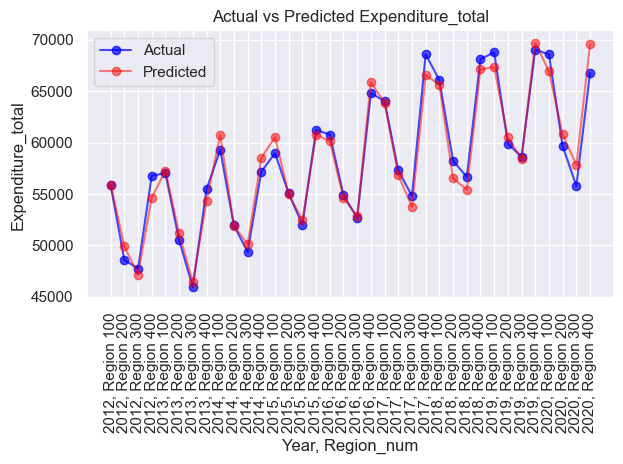

In [34]:
# Predict using the test data
model = m
Y_pred = model.predict(X_train)

# Extracting the 'Year', 'Expenditure_total', and 'Region_num' values for the test data
years = X_train['Year'].values
region_nums = X_train['Region_num'].values

# Combine 'Year' and 'Region_num' to form a combined label for x-axis
x_ticks_labels = [f"{year}, Region {region_num}" for year, region_num in zip(years, region_nums)]

# Scatter plot for actual 'Expenditure_total' values with combined 'Year' and 'Region_num' labels on x-axis
#plt.scatter(x_ticks_labels, Y_train, color='blue', label='Actual', alpha=0.7)
plt.plot(x_ticks_labels, Y_train, color='blue', label='Actual', marker='o', linestyle='-', alpha=0.7)


# Scatter plot for predicted 'Expenditure_total' values with combined 'Year' and 'Region_num' labels on x-axis
#plt.scatter(x_ticks_labels, Y_pred, color='red', label='Predicted', alpha=0.5)
plt.plot(x_ticks_labels, Y_pred, color='red', label='Predicted',marker='o', linestyle='-', alpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Labels and title
plt.xlabel('Year, Region_num')
plt.ylabel('Expenditure_total')
plt.title('Actual vs Predicted Expenditure_total')

# Show legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

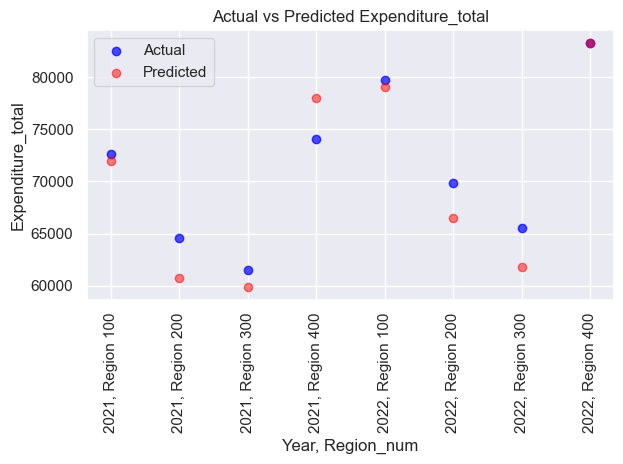

In [35]:
import matplotlib.pyplot as plt

# Extracting the 'Year', 'Expenditure_total', and 'Region_num' values for the test data
years = test_data['Year'].values
region_nums = test_data['Region_num'].values
Y_pred = model.predict(X_test)

# Combine 'Year' and 'Region_num' to form a combined label for x-axis
x_ticks_labels = [f"{year}, Region {region_num}" for year, region_num in zip(years, region_nums)]

# Scatter plot for actual 'Expenditure_total' values with combined 'Year' and 'Region_num' labels on x-axis
plt.scatter(x_ticks_labels, Y_test, color='blue', label='Actual', alpha=0.7)

# Scatter plot for predicted 'Expenditure_total' values with combined 'Year' and 'Region_num' labels on x-axis
plt.scatter(x_ticks_labels, Y_pred, color='red', label='Predicted', alpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Labels and title
plt.xlabel('Year, Region_num')
plt.ylabel('Expenditure_total')
plt.title('Actual vs Predicted Expenditure_total')

# Show legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


This model does a better job in "fitting" the traning data and predicts the 2022 spike in Expenditure for the region 400 (West).

However, some of the other predictions seems to be worse than the simple linear model, which could be a result of "overfitting" on the train data and then augmenting the variance in the "never seen" test data.


### Forward Stepwise Refinement & Multi-predictor model

We will now use other features in the dataset to gradually add the "best predictor" up to a list of 6. We are using the features that are clearly not part of the expenditure breakdown and coming from other macroeconomic datasets. See the allowed_factors list.

In order to do that , we will set up a regression model with $k$ factors that involves the fixed predictors from the previous step $k-1$

* Try all $p$ predictors in the new $k$th position
* Select the best parameter using $\textit{Adjusted}-R^2$ (e.g. `model.rsquared_adj`) given your training data
* Fix the new parameter and continue the process for $k+1$

### Model and training


In [36]:
allowed_factors = ['Year', 'Income_before_taxes', 'Annual_CPI', 'House_price',
       'Region_num', 'Employment_rate']

In [37]:
formula_chain = 'Expenditure_total ~'
X_train = df[(df['Year'] >= 2012) & (df['Year'] <= 2020)]
X_test = df[(df['Year'] >= 2021) & (df['Year'] <= 2022)]
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
Y_test = X_test['Expenditure_total']  # Target variable
Y_train = X_train['Expenditure_total']  # Target variable

train =[]
test = []

for i in range(len(allowed_factors)) :
    best = ['',0]

    for p in allowed_factors:
        model  = smf.ols(formula= formula_chain + str(' + ') + p, data=X_train).fit()
        if model.rsquared>best[1]:
            best = [p, model.rsquared]
    print('best:',best)
    formula_chain = formula_chain + str(' + ') + str(best[0])
    model  = smf.ols(formula= formula_chain, data=X_train).fit()
    train.append(model)
    model  = smf.ols(formula= formula_chain, data=X_test).fit()
    test.append(model)


X_train: (36, 10)
X_test: (8, 10)
best: ['Income_before_taxes', 0.8798355503489361]
best: ['House_price', 0.9061379883738019]
best: ['Employment_rate', 0.9365174480827176]
best: ['Region_num', 0.9397437616537183]
best: ['Year', 0.9398059918720612]
best: ['Annual_CPI', 0.9400968830089957]


Listed below are the 6 best predictors resulting from the iterative process to determine the best combination.

Now we will plot the $\textit{Adjusted}-R^2$ from the train and test models to determine what is the optimal combination of predictors.


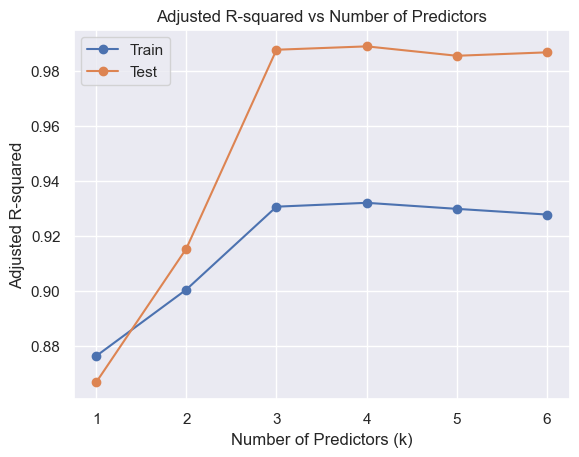

In [38]:
# plot resulting adjusted rsquared vs number of predictors (k=1,2,3,4,5,6)
# overlay the adjusted rsquared for the test data 
adjr2_train = []
adjr2_test = []
for i in range(len(train)):
    adjr2_train.append(train[i].rsquared_adj)
for j in range(len(test)):
    adjr2_test.append(test[j].rsquared_adj)
plt.plot(range(1, len(adjr2_train) + 1), adjr2_train, marker='o', label='Train')
plt.plot(range(1, len(adjr2_test) + 1), adjr2_test, marker='o', label='Test')
plt.xlabel('Number of Predictors (k)')
plt.ylabel('Adjusted R-squared')
plt.title('Adjusted R-squared vs Number of Predictors')
plt.legend()
plt.show()

The "sweet spot" seems with the inclusion of 3 predictors. Up to that value both the accuracy of the training and test models improve notably and then stay flat or even decline. 


For that reason, for our analysis we will ***select as "best model" the one resulting from the combination of the first 3 best predictors*** as it delivers the best balance between complexity and accuracy limiting in this way the risk of overfitting future data.

Below we will plot both the most simple model with one predictor and our "best model" with 3 predictors both for the training and test data and will come to conclusion on the results.

### Results

### ***1-Predictor Model***

                            OLS Regression Results                            
Dep. Variable:      Expenditure_total   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     248.9
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           3.28e-17
Time:                        20:51:40   Log-Likelihood:                -327.95
No. Observations:                  36   AIC:                             659.9
Df Residuals:                      34   BIC:                             663.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.272e+04   2

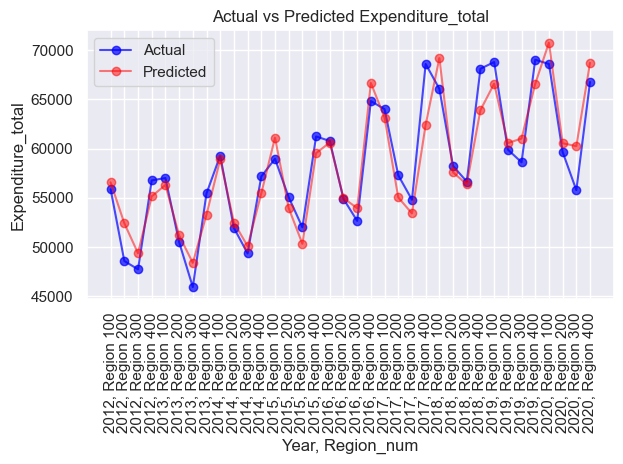

In [39]:
# Predict using the test data
model = train[0]
print(model.summary())
Y_pred = model.predict(X_train)

# Extracting the 'Year', 'Expenditure_total', and 'Region_num' values for the test data
years = X_train['Year'].values
region_nums = X_train['Region_num'].values

# Combine 'Year' and 'Region_num' to form a combined label for x-axis
x_ticks_labels = [f"{year}, Region {region_num}" for year, region_num in zip(years, region_nums)]

# Scatter plot for actual 'Expenditure_total' values with combined 'Year' and 'Region_num' labels on x-axis
#plt.scatter(x_ticks_labels, Y_train, color='blue', label='Actual', alpha=0.7)
plt.plot(x_ticks_labels, Y_train, color='blue', label='Actual', marker='o', linestyle='-', alpha=0.7)


# Scatter plot for predicted 'Expenditure_total' values with combined 'Year' and 'Region_num' labels on x-axis
#plt.scatter(x_ticks_labels, Y_pred, color='red', label='Predicted', alpha=0.5)
plt.plot(x_ticks_labels, Y_pred, color='red', label='Predicted',marker='o', linestyle='-', alpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Labels and title
plt.xlabel('Year, Region_num')
plt.ylabel('Expenditure_total')
plt.title('Actual vs Predicted Expenditure_total')

# Show legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

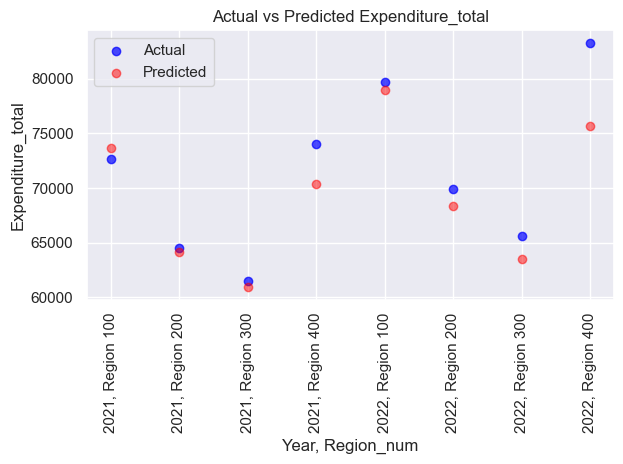

In [40]:
# Predict using the test data
model = train[0]
Y_pred = model.predict(X_test)
# Extracting the 'Year', 'Expenditure_total', and 'Region_num' values for the test data
years = X_test['Year'].values
region_nums = X_test['Region_num'].values

# Combine 'Year' and 'Region_num' to form a combined label for x-axis
x_ticks_labels = [f"{year}, Region {region_num}" for year, region_num in zip(years, region_nums)]

# Scatter plot for actual 'Expenditure_total' values with combined 'Year' and 'Region_num' labels on x-axis
plt.scatter(x_ticks_labels, Y_test, color='blue', label='Actual', alpha=0.7)

# Scatter plot for predicted 'Expenditure_total' values with combined 'Year' and 'Region_num' labels on x-axis
plt.scatter(x_ticks_labels, Y_pred, color='red', label='Predicted', alpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Labels and title
plt.xlabel('Year, Region_num')
plt.ylabel('Expenditure_total')
plt.title('Actual vs Predicted Expenditure_total')

# Show legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

### Results
### ***3-Predictors Model***

                            OLS Regression Results                            
Dep. Variable:      Expenditure_total   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     157.4
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           3.12e-19
Time:                        20:51:40   Log-Likelihood:                -316.46
No. Observations:                  36   AIC:                             640.9
Df Residuals:                      32   BIC:                             647.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -3.243e+04   1

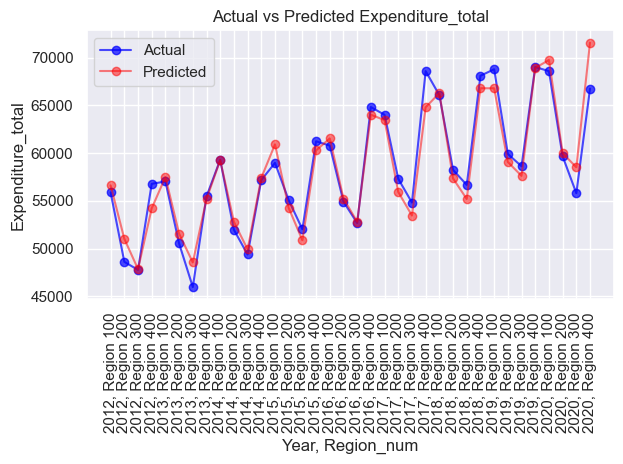

In [41]:
# Predict using the test data
model = train[2]
print(model.summary())
Y_pred = model.predict(X_train)

# Extracting the 'Year', 'Expenditure_total', and 'Region_num' values for the test data
years = X_train['Year'].values
region_nums = X_train['Region_num'].values

# Combine 'Year' and 'Region_num' to form a combined label for x-axis
x_ticks_labels = [f"{year}, Region {region_num}" for year, region_num in zip(years, region_nums)]

# Scatter plot for actual 'Expenditure_total' values with combined 'Year' and 'Region_num' labels on x-axis
#plt.scatter(x_ticks_labels, Y_train, color='blue', label='Actual', alpha=0.7)
plt.plot(x_ticks_labels, Y_train, color='blue', label='Actual', marker='o', linestyle='-', alpha=0.7)


# Scatter plot for predicted 'Expenditure_total' values with combined 'Year' and 'Region_num' labels on x-axis
#plt.scatter(x_ticks_labels, Y_pred, color='red', label='Predicted', alpha=0.5)
plt.plot(x_ticks_labels, Y_pred, color='red', label='Predicted',marker='o', linestyle='-', alpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Labels and title
plt.xlabel('Year, Region_num')
plt.ylabel('Expenditure_total')
plt.title('Actual vs Predicted Expenditure_total')

# Show legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

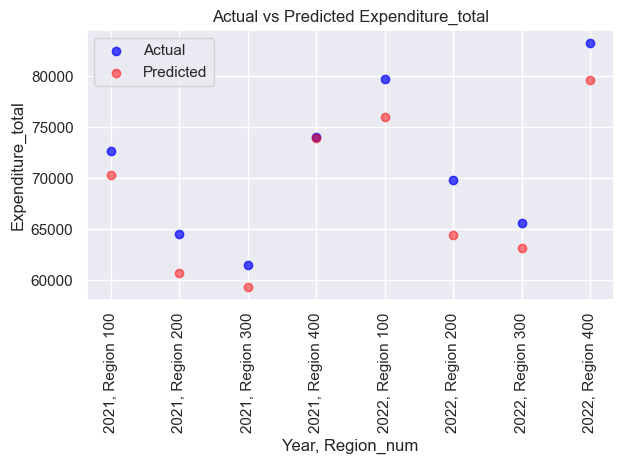

In [42]:
# Predict using the test data
model = train[2]
Y_pred = model.predict(X_test)
# Extracting the 'Year', 'Expenditure_total', and 'Region_num' values for the test data
years = X_test['Year'].values
region_nums = X_test['Region_num'].values

# Combine 'Year' and 'Region_num' to form a combined label for x-axis
x_ticks_labels = [f"{year}, Region {region_num}" for year, region_num in zip(years, region_nums)]
plt.scatter(x_ticks_labels, Y_test, color='blue', label='Actual', alpha=0.7)
plt.scatter(x_ticks_labels, Y_pred, color='red', label='Predicted', alpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Labels and title
plt.xlabel('Year, Region_num')
plt.ylabel('Expenditure_total')
plt.title('Actual vs Predicted Expenditure_total')

# Show legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

### Results discussion

The comparaison between the 1-predictor model with the 3-predictor model is quite interesting.

Obviously, the R-squared for the 3-predictor model is better that 1-predictor model (0.880 vs 0.937), but overall the 1-predictor model is more accurate in more of its predictions but very bad at predicting the value for the Region 400 (West). 

The 3-predictor model predictions doe not come as close as the 1-predictor model in most values but correctly predicts the values for the Region 400, so it is consistent accros the different data points.

Before concluding, we will do a final comparaison between the two models and use them to predict the total Expenditure for 2023 for the South Region assuming that the Income before taxes will increase slightly. I have also gathered the current (as of Oct 2023) CPI and House prices for the region to make the test more realistic. 

Here are the predicted values by the two models:

In [43]:
X_test

,Year,Income_before_taxes,Expenditure_total,Transportation,Healthcare,Employment_rate,Unemployment_rate,Annual_CPI,House_price,Region_num
4,2021,100103,72678,9918,5759,0.590,0.074,283.557,366749.1869,100
5,2021,84454,64542,10165,5834,0.604,0.054,252.242,223231.1175,200
6,2021,79148,61473,11203,5107,0.575,0.058,261.259,268473.9578,300
7,2021,94666,74033,12083,5447,0.583,0.071,287.494,458290.1995,400
0,2022,108768,79741,12093,6069,0.610,0.046,303.320,400411.3643,100
1,2022,91430,69870,11912,6569,0.617,0.038,272.401,241918.1104,200
2,2022,83346,65576,11932,5376,0.592,0.042,283.666,290890.0814,300
3,2022,103418,83317,13420,5828,0.604,0.046,310.509,489353.0737,400


In [44]:
# data entered manually with assumptions in income before taxes.
# Employment rate, CPI and House_price are the year-to-date (Oct23) values.
data = {
    'Year': [2023],
    'Income_before_taxes': [85000],
    'Expenditure_total': [0],
    'Transportation': [0],
    'Healthcare': [0],
    'Employment_rate': [0.6125],
    'Unemployment_rate': [0],
    'Annual_CPI': [300],
    'House_price': [296500],
    'Region_num': [300]
}
entry_data = pd.DataFrame(data)
entry_data

,Year,Income_before_taxes,Expenditure_total,Transportation,Healthcare,Employment_rate,Unemployment_rate,Annual_CPI,House_price,Region_num
0,2023,85000,0,0,0,0.6125,0,300,296500,300


In [45]:
model = train[0]
Y_pred = model.predict(entry_data)
formatted_amount = '${:,.2f}'.format(Y_pred[0])
print('Predicted Expenditure for Region South in 2023',formatted_amount)
value_v = X_test.loc[(X_test['Year'] == 2022) & (X_test['Region_num'] == 300), 'Expenditure_total']
value = value_v.values
percentage = pd.to_numeric((Y_pred[0] - value )*100/ value)
print('This is a ',percentage,'% variation')

Predicted Expenditure for Region South in 2023 $64,476.80
This is a  [-1.67622938] % variation


In [46]:
model = train[2]
Y_pred = model.predict(entry_data)
formatted_amount = '${:,.2f}'.format(Y_pred[0])
print('Predicted Expenditure for Region South in 2023',formatted_amount)
value_v = X_test.loc[(X_test['Year'] == 2022) & (X_test['Region_num'] == 300), 'Expenditure_total']
value = value_v.values
percentage = pd.to_numeric((Y_pred[0] - value )*100/ value)
print('This is a ',percentage,'% variation')

Predicted Expenditure for Region South in 2023 $66,015.77
This is a  [0.67063319] % variation


The ***1-predictor*** model predicts a total expenditure of 64,476.80 for 2023 in the South Region while the ***3-predictor*** model outputs a total expenditure of 66,015.77.

While the first one is predicting a small decline of -1.64% the second predict a small increase of 0.67% as compared to 2022. 

At first sight, it looks like the results seem to confirm that the 3-predictor model is actually the best fit as it is expected that this year the expenditure increases (as it has done over the years) accentuated by the raise of inflation.

Obviously, this is just a data point and we still need to have all the parameters to confirm the adequacy of our choice but it is confirming that we are in the right direction.

We will need to the end of 2023 to have the final confirmation ;-)

# Conclusion

In this project, we have collected data from public sources to build a supervised learning model that can predict the evolution of the annual cost of living for U.S. Households based on the US macroeconomic indicators.

The selected target variable that better represent the cost of living is the annual total expenditure. The features tested as predictors reflect the inflation (Annual CPI), unemployment (employment/unemployment rates) and housing prices.

A first correlation analysis of the different features imported along with these dataset has determine that there is enough correlation between the target variable and the features coming from the macroeconomic indicators.

Thanks to data visualization and plots we have confirmed the correlation analysis mentioned below, with one anomaly to be taken into account around the year 2020. The COVID pandemic impacted negatively the employment but, the effect in the expenditure was not as acute thanks to the government subsidies and policies. Also the house prices actually increased more than the trend in 2020-2021 as a consequence of the low supply. 
After pandemic, the inflation (CPI) surged and we could clearly see that the index slope was much steeper than the expenditure in the years after 2020. These are "one off" effects make the linear predictions challenging to fit these irregularities and our model will have to deal with it.

A first simple linear model was attempted using the best predictor (Income_before_taxes) that showed the  R-squared score of 0.880 is already quite good. We attempted as well a multi-linear model taking into consideration all availables features to obtained actually a worse R-squared score of 0.850. However, this model managed to better fit some of the data points (region 400) that were clearly badly predicted by the simple linear model.

In order to come up with a better model, we use the forward stepwise refinement technique to come up with a multi-predictor model that could delivered better results. We recursively attempted a combination of up to 6 "best preditors" to finally come to the conclusion that the optimal model efficiency for the training and test data was achieved with a 3-predictor model.

By visualizing the results and comparing with the 1-predictor model, the 3-predictor model (besides obviously having a better R-square of 0.937) does a better job of fitting and predicting the overall test data, hence confirming the conclusion achieved by analytical methods.

According to the optimal model the 2013 total expenditure in the South Region will beo 66,015.77 ... let's see how that compares to reality when the year comes to an end.
